In [1]:
# Interface detector based on max_gradient_classifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def mov_avg(array, window_length, *, method='same'):
    array_avg = np.convolve(array, np.ones(window_length), method) / window_length
    return array_avg

## Synthetic Data
I used this for development and testing. You will find an example with a proper profile later in the document.

In [34]:
result_grid = np.ones([250, 1000])
result_grid[0:51, :] = 0
result_grid[51:101, :] = 1
result_grid[101:151, :] = 2
result_grid[151:201, :] = 3
result_grid[201:250, :] = 4
depths = np.linspace(0, 200, 250)
result_grid_rolled = np.roll(result_grid, -1, axis=0)
result = result_grid - result_grid_rolled
result[-1, :] = 0

In [36]:
interface_id = []
interface_n = []
for column in result.T:
    indexes = np.where(column != 0)
    interface_n.append(len(indexes[0]))
    interface_id.append(indexes)
interface_id[0] =  [np.array([50, 100, 150])]
interface_id[5] = [np.array([100, 150])]
interface_id[-1] = [np.array([50, 200])]
interface_number = np.bincount(interface_n).argmax()
#print(result.shape[1])
interface_depths_ids = np.ones([interface_number, result.shape[1]])*float("NaN")
interface_depths = np.ones([interface_number, result.shape[1]])*float("NaN")
incomplete_detections = []
for col_num in range(len(interface_id)):
    if len(interface_id[col_num][0]) == interface_number:
        interface_depths_ids[:, col_num] = interface_id[col_num][0]
        interface_depths[:, col_num] = depths[interface_id[col_num][0]]
    else:
        incomplete_detections.append(col_num)

In [44]:
for col_num_inc in incomplete_detections:
    if col_num_inc is 0:
        new_ids = np.ones([interface_number, 1])*float("NaN")
        for depth_id in interface_id[col_num_inc][0]:
            depth_id_array = np.ones([interface_number, 1])*depth_id
            diff = interface_depths[:, col_num_inc+1].reshape([interface_number, 1]) - depth_id_array
            pos = np.where(abs(diff).reshape([len(diff)]) == np.amin(abs(diff)))
            new_ids[int(pos[0])] = depths[depth_id]
        interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])
    elif col_num_inc == result.shape[1]-1:
        new_ids = np.ones([interface_number, 1])*float("NaN")
        for depth_id in interface_id[col_num_inc][0]:
            depth_id_array = np.ones([interface_number, 1])*depth_id
            diff = interface_depths[:, col_num_inc-1].reshape([interface_number, 1]) - depth_id_array
            pos = np.where(abs(diff).reshape([len(diff)]) == np.amin(abs(diff)))
            new_ids[int(pos[0])] = depths[depth_id]
        interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])
    else:
        print('a')
        new_ids = np.ones([interface_number, 1])*float("NaN")
        for depth_id in interface_id[col_num_inc][0]:
            depth_id_array = np.ones([interface_number, 1])*depth_id
            diff = ((interface_depths[:, col_num_inc-1].reshape([interface_number, 1])+interface_depths[:, col_num_inc-1].reshape([interface_number, 1]))/2) - depth_id_array
            print(diff.reshape([len(diff)]))
            print(np.amin(abs(diff)))
            pos = np.where(abs(diff).reshape([len(diff)]) == np.amin(abs(diff)))
            new_ids[int(pos[0])] = depths[depth_id]
        interface_depths[:,col_num_inc] = new_ids.reshape([interface_number])


a
[-59.83935743 -19.67871486  20.48192771  60.64257028]
19.678714859437747
[-109.83935743  -69.67871486  -29.51807229   10.64257028]
10.642570281124506


## Inverted profile
#### Load data

In [2]:
xi = pd.read_csv('interface_detector_demo/xi_demo.csv', skiprows=1).drop(columns='0').to_numpy()
yi = pd.read_csv('interface_detector_demo/yi_demo.csv', skiprows=1).drop(columns='0').to_numpy()
y_pred_grid_deri = pd.read_csv('interface_detector_demo/profile_grided_derivative.csv', skiprows=1).drop(columns='0').to_numpy()
y_pred_grid_deri[-1, :] = 0

You won't see anything in the next figure. y_pred_grid_deri is a result of substracting rolled profile from itself. Therefore only non zero values are the ones that are related to change of class in the colum.

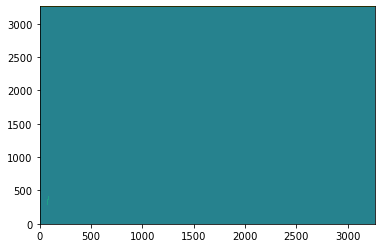

In [41]:
plt.contourf(y_pred_grid_deri)

In [3]:
min_thickness = 1  # Minimal thickness of layer in m
interface_id = []
interface_n = []
interface_depth = []
for column in y_pred_grid_deri.T:
    indexes = list(np.where(column != 0))
    if indexes[0].size == 1:  # Only one interface detected
        interface_n.append(len(indexes[0]))
        interface_id.append(indexes)
        interface_depth.append(yi[indexes])
    else:  # Multiple potential interfaces detected
        indexes_temp = []
        depths_temp = []
        indexes_copy = indexes
        all_too_thin_layers_removed = False
        while all_too_thin_layers_removed is False:
            all_too_thin_layers_removed = True
            if isinstance(indexes_copy[0], int) is False:
                for index_id in range(indexes_copy[0].size-1):
                    diff = yi[indexes[0][index_id+1]] - yi[indexes[0][index_id]]
                    if abs(diff) <= min_thickness:
                        indexes_temp.append(int(round((indexes[0][index_id+1]+indexes[0][index_id])/2)))
                        all_too_thin_layers_removed = False
                    else:
                        indexes_temp.append(indexes[0][index_id])
                if abs(yi[indexes[0][-1]] - yi[indexes[0][-2]]) >= min_thickness:
                    indexes_temp.append(indexes[0][-1])
                indexes_copy = indexes_temp
                indexes_temp = []
        interface_n.append(len(indexes_copy))
        interface_id.append(indexes_copy)
        interface_depth.append(yi[indexes_copy])
interface_number = np.bincount(interface_n).argmax()

/home/felikskrno/anaconda3/envs/SlopeStability/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


This test profile contains only one interface. Results should only contain one interface, but everywhere where interface_n has value greater than 1 and where interface_id and interface_depth contain arrays with multiple values, the distance between two potential interfaces exceeded threshold defined in min_thickness

In [ ]:
print(interface_number)
print(interface_n)
print(interface_id)
#print(interface_depth)